In [1]:
# ------------------------------------------------------------------------------
# Description:
#
#  The main program for cloud top height retrieval using two simultaneous 
#  GEO observations.
#
# Method:
#
# (1) Reads two GEO digital number.
# (2) Selects cloud target and slice images.
# (3) Image matching based on the NCC method.
# (4) Cloud top height retrieval by the iterative process.
# (5) Post-process cloud top height products.
#
# History:
#
# Version  Date      Comment
# -------  ----      -------
# 1.0      19/02/21  Original version.  Jonghyuk Lee (Yonsei Univ.)
# 1.1      20/03/05  Change to Python.  Jonghyuk Lee (Yonsei Univ.)
# 
#
# References:
#
# (1) Hasler, 1981 
#     Stereographic Observations from Geosynchronous Satellties:
#     An Important New Tool for the Atmospheric Sciences.
# (2) Wylie et al., 1998
#     Cloud-Top Heights from GOES-8 and GOES-9 Stereoscopic Imagery.
# (3) Seiz et al., 2007
#     Multiview Cloud-Top Height and Wind Retrieval with Photogrammetric Method:
#     Application to Meteosat-8 HRV Observations.
# (4) Zaksek et al., 2013
#     Monitoring volcanic ash cloud top height through simultaneous retrieval of
#     optical data from polar orbiting and geostationary satellites.
#
#
# Code Description:
#   Language:      Python 3.8
# 
# End of header ----------------------------------------------------------------                                

## 알고리즘 준비

1. 필요한 라이브러리 불러오기

In [2]:
import sys
sys.path.append('/sdata_storage/jhlee/JUPYTER/code_dev/module/')
import numpy as np
import read_satellite_data as read
import slice_satellite_data as slice
import remap_satellite_data as remap
import matplotlib.pyplot as plt

2. 입력 변수 정의

In [3]:
# 입력 파일 경로/날짜
himawari8_path = '/storage1/jhlee/NMSC_2018/Himawari_8_AHI/'
himawari8_date1 = '201711030530'
himawari8_date2 = '201711030540'
fy2e_path = '/storage1/jhlee/NMSC_2018/FY_2E_VISSR/'
fy2e_date = '20171103_0530'

# 목표 영역 정의
left_upper_lat = 30.
left_upper_lon = 116.
right_lower_lat = 23.
right_lower_lon = 127.

## 알고리즘 시작

1. 위성자료 읽기
 - Level 1B 위성 자료 읽기 (디지털 값)
 - 위/경도 자료 읽기
 - fy2e 구름 정보 읽기

In [4]:
himawari8 = read.himawari8()
fy2e = read.fy2e()

# Level 1B 디지털 값
himawari8_DN1 = himawari8.read_L1b(himawari8_path, himawari8_date1)
himawari8_DN2 = himawari8.read_L1b(himawari8_path, himawari8_date2)
fy2e_DN, fy2e_clc = fy2e.read_L1b(fy2e_path, fy2e_date)


# 위/경도 자료
himawari8_lat, himawari8_lon = himawari8.read_latlon(himawari8_path)
fy2e_lat, fy2e_lon = fy2e.read_latlon(fy2e_path)

2. 위성자료 리매핑
 - 목표 영역 slicing
 - image sliceping

In [5]:
# Himawari8 목표 영역 slicing (Himawari8 영역은 조금 더 크게 한다.)
cut_himawari8_DN1 = slice.cut_with_latlon_geos(himawari8_DN1, 'himawari8',
                                               left_upper_lat + 3 , left_upper_lon - 3, 
                                               right_lower_lat - 3, right_lower_lon + 3)
cut_himawari8_DN2 = slice.cut_with_latlon_geos(himawari8_DN2, 'himawari8', 
                                               left_upper_lat + 3 , left_upper_lon - 3, 
                                               right_lower_lat - 3, right_lower_lon + 3)
cut_himawari8_lat = slice.cut_with_latlon_geos(himawari8_lat, 'himawari8', 
                                               left_upper_lat + 3 , left_upper_lon - 3,
                                               right_lower_lat - 3, right_lower_lon + 3)
cut_himawari8_lon = slice.cut_with_latlon_geos(himawari8_lon, 'himawari8', 
                                               left_upper_lat + 3 , left_upper_lon - 3,
                                               right_lower_lat - 3, right_lower_lon + 3)

# FY-2E 목표 영역 slicing
cut_fy2e_DN = slice.cut_with_latlon_geos(fy2e_DN,'fy2e', 
                                         left_upper_lat + 1, left_upper_lon - 1, 
                                         right_lower_lat - 1, right_lower_lon + 1)
cut_fy2e_lat = slice.cut_with_latlon_geos(fy2e_lat, 'fy2e', 
                                          left_upper_lat + 1, left_upper_lon - 1, 
                                          right_lower_lat - 1, right_lower_lon + 1)
cut_fy2e_lon = slice.cut_with_latlon_geos(fy2e_lon, 'fy2e', 
                                          left_upper_lat + 1, left_upper_lon - 1, 
                                          right_lower_lat - 1, right_lower_lon + 1)

# 필요없는 변수 메모리 삭제
del(himawari8_DN1); del(himawari8_DN2); del(himawari8_lat); del(himawari8_lon)
del(fy2e_DN); del(fy2e_lat); del(fy2e_lon)

## remap (inverse distance weighting test)

In [6]:
x = [-47.6, -48.9, -48.2, -48.9, -47.6, -48.6]
y = [-23.4, -24.0, -23.9, -23.1, -22.7, -22.5]
z = [27.0,  33.4,  34.6,  18.2,   30.8, 42.8]

In [7]:
xi = [-48.0530600]
yi = [-23.5916700]

In [8]:
remap.idwr(x,y,z,xi,yi)

[[-48.05306, -23.59167, 32.549720867463115]]

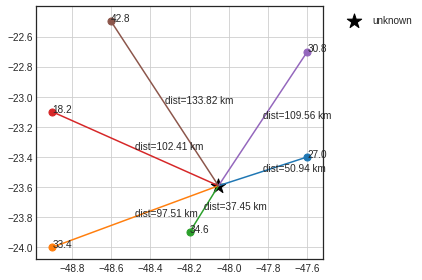

In [10]:
import matplotlib.pyplot as plt
import matplotlib.style as style
style.available
style.use('seaborn-white')
dists = [50.93664088924365, 97.50798854810864, 37.44644402279387, 102.4130216426453, 109.55825855482198, 133.81580425549404]
len(dists)
for i in range(len(x)):
    plt.scatter(x = x[i],
                y = y[i],
                s = 50)
    plt.annotate(xy = (x[i],y[i]),      
                 s=z[i])
    plt.annotate(xy = ( ((x[i] + xi[0]) / 2), ((y[i] + yi[0]) / 2)),      
                 s= 'dist='+ str(np.round(dists[i],2))+ ' km')
    lcx = [xi[0], x[i]]
    lcy = [yi[0], y[i]]
    plt.plot(lcx,lcy)    
plt.scatter(xi,yi,
            c='black', s=230, label='unknown', marker='*')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout()
plt.grid(True)
plt.show()